In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

import scipy.stats as sp_stats

init_time = time.time()

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCASingleClassSVM'
# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.pickle'%(subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.pickle'%(subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = pickle.load(open(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.pickle'%(subfolder,n_pts_fft,decimation_rate), "rb" ))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

/Users/natmourajr/.virtualenvs/sonar/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Time to import all libraries: 100.14568305 seconds
Time to read data file: 20.3392071724 seconds


In [25]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")
print log_entries

{0: {'date': '2016_07_10_19_33_04', 'package': 'PCASingleClassSVM'}, 1: {'date': '2016_07_10_19_36_50', 'package': 'PCASingleClassSVM'}, 2: {'date': '2016_07_11_17_40_53', 'package': 'PCASingleClassSVM'}, 3: {'date': '2016_07_11_17_41_38', 'package': 'PCASingleClassSVM'}, 4: {'date': '2016_07_11_18_25_06', 'package': 'PCASingleClassSVM'}, 5: {'date': '2016_07_11_18_25_35', 'package': 'PCASingleClassSVM'}}


Analysing train performed in 2016_07_11_18_25_35 and for PCASingleClassSVM analysis
Recovering for Novelty ClassA - fold 0 of 2, Nu value: 0.100000
Recovering for Novelty ClassA - fold 1 of 2, Nu value: 0.100000
Recovering for Novelty ClassA - fold 0 of 2, Nu value: 0.200000
Recovering for Novelty ClassA - fold 1 of 2, Nu value: 0.200000
Recovering for Novelty ClassA - fold 0 of 2, Nu value: 0.500000
Recovering for Novelty ClassA - fold 1 of 2, Nu value: 0.500000
Recovering for Novelty ClassB - fold 0 of 2, Nu value: 0.100000
Recovering for Novelty ClassB - fold 1 of 2, Nu value: 0.100000
Recovering for Novelty ClassB - fold 0 of 2, Nu value: 0.200000
Recovering for Novelty ClassB - fold 1 of 2, Nu value: 0.200000
Recovering for Novelty ClassB - fold 0 of 2, Nu value: 0.500000
Recovering for Novelty ClassB - fold 1 of 2, Nu value: 0.500000
Recovering for Novelty ClassC - fold 0 of 2, Nu value: 0.100000
Recovering for Novelty ClassC - fold 1 of 2, Nu value: 0.100000
Recovering for Novel

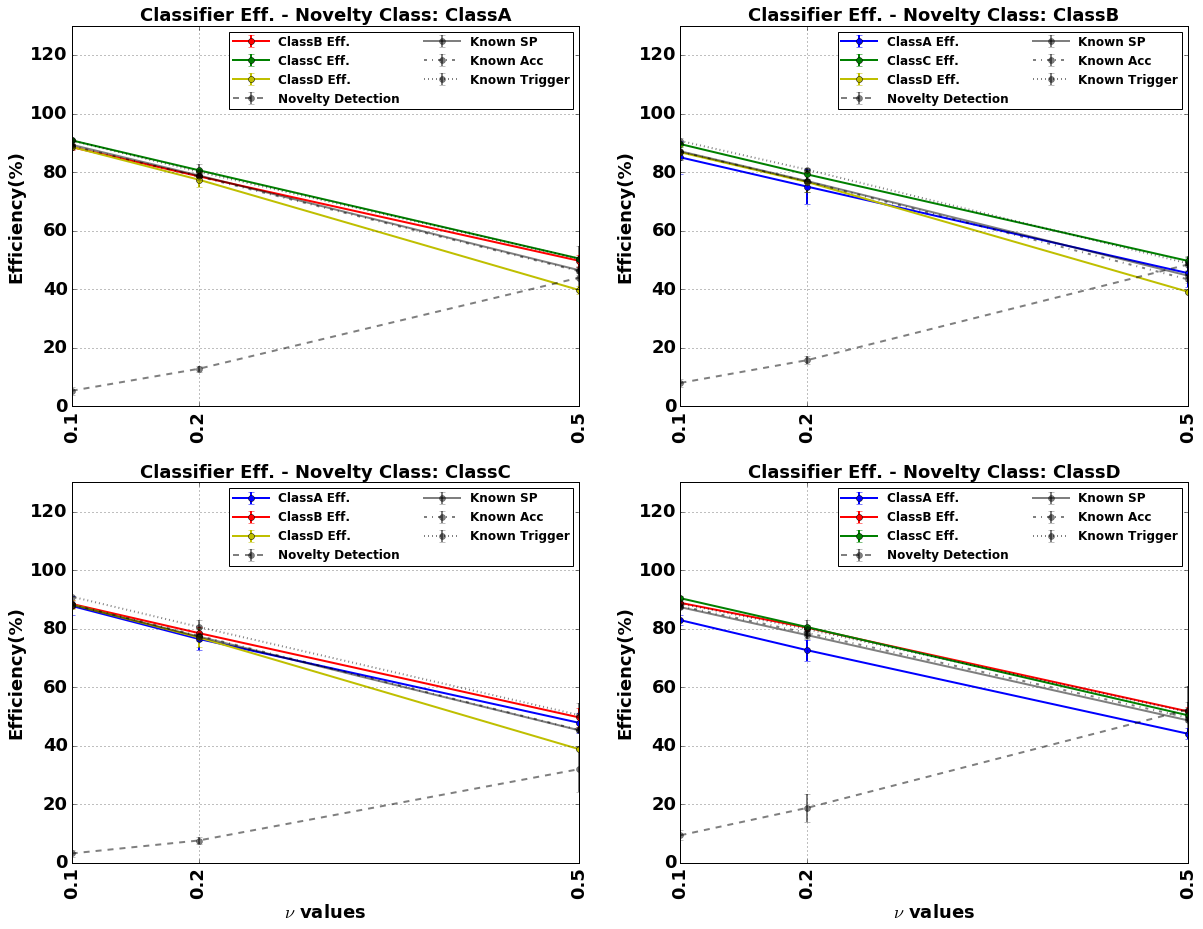

In [69]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_11_18_25_35'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    # Read Result info file
    result_base_name = '%s/result_files'%(result_analysis_path)
    picts_base_name = '%s/picts'%(result_analysis_path)
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        # if file exists, do the analysis
        results = {}
        [train_info] = joblib.load(train_info_name)
        for novelty_class, novelty_label in enumerate(class_labels):
            results[novelty_label] = {}
            for iclass, class_label in enumerate(class_labels):
                if novelty_class == iclass: continue
                results[novelty_label][class_label] = np.zeros([len(train_info['nu_values']),
                                                                len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Novelty Detector'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Accuracy'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Trigger'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                    print "Recovering for Novelty %s - fold %i of %i, Nu value: %f"%(
                        novelty_label,ifold,len(train_info['CVO_%s'%(novelty_label)]),nu_value)
                    results_file = np.loadtxt('%s/%s_%s_novelty_%i_fold_%f_nu.txt'%
                                (result_base_name, log_entries[log_id]['date'],novelty_label,ifold,nu_value))
                    # compute class eff
                    total_known_correct_events = 0
                    total_known_events = 0;
                    for iclass, class_label in enumerate(class_labels):
                        if iclass == novelty_class: continue
                        total_known_correct_events = (total_known_correct_events+
                                                      float(sum(results_file[results_file[:,4]==iclass,
                                                                iclass-(iclass>novelty_class)]>0)))
                        total_known_events = total_known_events+float(sum(results_file[:,4]==iclass))
                        results[novelty_label][class_label][nu_id,ifold] = (
                            float(sum(results_file[results_file[:,4]==iclass,iclass-(iclass>novelty_class)]>0))/
                                                                            sum(results_file[:,4]==iclass))
                    results[novelty_label]['Novelty Detector'][nu_id,ifold] = (
                        float(sum(results_file[results_file[:,4]==novelty_class,3]<0))/
                                                                    sum(results_file[:,4]==novelty_class))
                    results[novelty_label]['Accuracy'][nu_id,ifold] = (total_known_correct_events/
                                                                               total_known_events)
                    results[novelty_label]['Trigger'][nu_id,ifold] = (
                        float(sum(results_file[results_file[:,4]!=novelty_class,3]>0))/
                                                                    sum(results_file[:,4]!=novelty_class)) 
    # Plot Efficiency
    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
    m_colors = ['b', 'r', 'g', 'y']
    for novelty_class, novelty_label in enumerate(class_labels):
        ax = plt.subplot(2,2,novelty_class+1)
        m_fontsize = 18
        plt.title('Classifier Eff. - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
        if novelty_class > 1:
            plt.xlabel(r'$\nu$ values', fontsize= m_fontsize, fontweight="bold")
        plt.ylabel('Efficiency(%)', fontsize= m_fontsize, fontweight="bold")
        m_leg = []

        for iclass, class_label in enumerate(class_labels):
            if iclass == novelty_class: continue
        
            # creating vectors
            mean_eff = np.zeros_like(train_info['nu_values'])
            std_eff = np.zeros_like(train_info['nu_values'])
        
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                mean_eff[nu_id] = np.mean(100*results[novelty_label][class_label][nu_id,:])
                std_eff[nu_id] = np.std(100*results[novelty_label][class_label][nu_id,:])
            plt.errorbar(train_info['nu_values'],mean_eff,std_eff,marker='o',color=m_colors[iclass])
            m_leg.append(class_label+' Eff.')
    
        mean_eff = np.zeros_like(train_info['nu_values'])
        std_eff = np.zeros_like(train_info['nu_values'])

        for nu_id, nu_value in enumerate(train_info['nu_values']):
            mean_eff[nu_id] = np.mean(100*results[novelty_label]['Novelty Detector'][nu_id,:])
            std_eff[nu_id] = np.std(100*results[novelty_label]['Novelty Detector'][nu_id,:])
        plt.errorbar(train_info['nu_values'],mean_eff,std_eff,marker='o',color='k',ls='--',alpha=0.5)
        m_leg.append('Novelty Detection')
    
        sp_vec = []
        for nu_id, nu_value in enumerate(train_info['nu_values']):
            eff_vec = []
            for iclass, class_label in enumerate(class_labels):
                if iclass == novelty_class: continue
                eff_vec.append(100*results[novelty_label][class_label][nu_id,:])
            sp_vec.append(np.sqrt(np.mean(eff_vec,axis=0)*sp_stats.gmean(eff_vec,axis=0)))
        
        mean_sp = np.mean(sp_vec,axis=1)
        std_sp = np.std(sp_vec,axis=1)
        plt.errorbar(train_info['nu_values'],mean_sp,std_sp,marker='o',color='k',alpha=0.5)
        m_leg.append('Known SP')
    
        mean_acc = np.mean(100*results[novelty_label]['Accuracy'],axis=1)
        std_acc = np.std(100*results[novelty_label]['Accuracy'],axis=1)
        plt.errorbar(train_info['nu_values'],mean_acc,std_acc,marker='o',color='k',ls='-.',alpha=0.5)
        m_leg.append('Known Acc')
    
        mean_tri = np.mean(100*results[novelty_label]['Trigger'],axis=1)
        std_tri = np.std(100*results[novelty_label]['Trigger'],axis=1)
        plt.errorbar(train_info['nu_values'],mean_tri,std_tri,marker='o',color='k',ls=':',alpha=0.5)
        m_leg.append('Known Trigger')
    
        m_x_labels = train_info['nu_values']
        
        # graphical assusts
        plt.xlim([np.min(m_x_labels), np.max(m_x_labels)])
        plt.ylim([0.0, 130])
        plt.xticks(m_x_labels,m_x_labels,rotation=90)
    
        plt.grid()
        plt.legend(m_leg, loc='upper right',ncol=2)
    pict_name = ('%s/%s_%s_eff_plot.pdf')%(picts_base_name,log_entries[log_id]['date'],
                                    log_entries[log_id]['package'])
    plt.savefig(pict_name)

In [65]:
np.mean(results[novelty_label]['Accuracy'],axis=1)

array([ 0.87785898,  0.78578601,  0.49670869])